In [1]:
import numpy as np
import sys
import os
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
sys.path.append(os.path.abspath('C:/Users/vpming/tuni_ml/src'))
from extract_data import build_cellwise_df_100samplesperfile, extract_noise

In [3]:
data_path = 'C:/Users/vpming/tuni_ml/data_7x7'
all_df = build_cellwise_df_100samplesperfile(data_path)

In [4]:
min_count = all_df['dis_to_target'].value_counts().min()

n_samples = min_count

# Balance the df
df = (
    all_df.groupby('dis_to_target', group_keys=False)
    .apply(lambda x: x.sample(n=n_samples, random_state=42))
    .reset_index(drop=True)
)

print(df['dis_to_target'].value_counts())

dis_to_target
0    12000
1    12000
2    12000
3    12000
4    12000
5    12000
Name: count, dtype: int64


C:\Users\vpming\AppData\Local\Temp\ipykernel_24176\1389712327.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_samples, random_state=42))


In [5]:
df['noise'] = df['simulation_file'].apply(extract_noise)

In [6]:
print(df['noise'].value_counts())

noise
0.03    15165
0.02    15071
0.01    15019
0.04    14829
0.05    11916
Name: count, dtype: int64


In [7]:
x = np.stack(df['time_trace'])

y = df['dis_to_target'].values

# 4 classes: 0, 1, 2, 3, 4, 5
n_bins = 6
bins = np.linspace(y.min(), y.max(), n_bins + 1)
y_class = np.digitize(y, bins[1:-1])  # produces class labels 0,1,2,3,4,5

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2, random_state=42)

# Scale only the input features
x_scaler = StandardScaler()
x_train_s = x_scaler.fit_transform(x_train)
x_test_s = x_scaler.transform(x_test)

# Do NOT scale y for classification!
train_ds = TensorDataset(torch.tensor(x_train_s, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(x_test_s, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [8]:
print(y_class)

[0 0 0 ... 5 5 5]


In [18]:
class CNNClassifier(nn.Module):
    def __init__(self, n_timepoints, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding=3),   
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 5, padding=2),   
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 3, padding=1),  
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten()
        )
        # Calculate the output size after 3 pools (divide by 8, integer division)
        linear_input_size = 128 * (n_timepoints // 8)
        self.fc = nn.Sequential(
            nn.Linear(linear_input_size, 256),  # Wider FC layer
            nn.ReLU(),
            nn.Dropout(0.3),                    # Regularization
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)    # [batch, 1, n_timepoints]
        x = self.conv(x)
        return self.fc(x)

In [10]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    avg_loss = running_loss / total
    acc = 100 * correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels

In [15]:
def fit(model, train_loader, test_loader, epochs=20):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = running_loss / total
        acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        # Evaluate on test
        test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, loss_fn)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}  Train Accuracy: {acc:.2f}%  Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.2f}%')
        
    torch.save({
        'model_state_dict': model.state_dict()
    }, "C:/Users/vpming/tuni_ml/src/model/balanced_cnn_classifier__cmax_cvar.pt")

    # Plot losses and accuracies
    epochs_range = np.arange(1, epochs+1)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    # Confusion matrix for final test predictions
    plt.subplot(1, 3, 3)
    conf_mat = confusion_matrix(test_labels, test_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return train_losses, test_losses, train_accs, test_accs, conf_mat

Epoch 5/20 Train Loss: 1.2358  Train Accuracy: 45.75%  Test Loss: 1.2752  Test Accuracy: 43.54%
Epoch 10/20 Train Loss: 0.9636  Train Accuracy: 60.18%  Test Loss: 1.4075  Test Accuracy: 40.52%
Epoch 15/20 Train Loss: 0.4153  Train Accuracy: 84.37%  Test Loss: 2.3046  Test Accuracy: 39.39%
Epoch 20/20 Train Loss: 0.2127  Train Accuracy: 92.46%  Test Loss: 3.0580  Test Accuracy: 38.88%


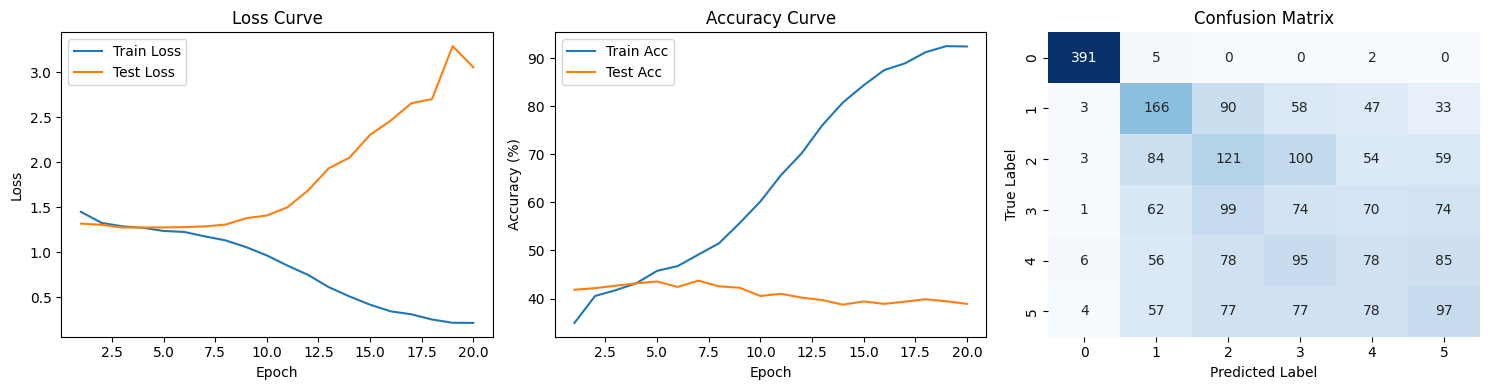

([1.4485059969574277,
  1.3256746126832053,
  1.28708656875716,
  1.270604076477544,
  1.235793147975539,
  1.2246703555791056,
  1.1750914302134383,
  1.1311091321684261,
  1.0559950794335229,
  0.9636157691553766,
  0.8502910349782254,
  0.7465632867773091,
  0.6104909912958597,
  0.5076704546277682,
  0.41530642715062704,
  0.3412761230129581,
  0.30837160604019104,
  0.24999360246814403,
  0.21401868113388897,
  0.21266682851829802],
 [1.3173794186355283,
  1.304056204405407,
  1.2740535960101442,
  1.2734986839678464,
  1.275155766698338,
  1.2783970184774207,
  1.286220734551449,
  1.3063348083688109,
  1.3770693708586212,
  1.40746150880852,
  1.4990996386380804,
  1.6869116453516404,
  1.9325957362283797,
  2.050806423161654,
  2.304629821905354,
  2.463752743381782,
  2.6567876995009865,
  2.7032245757595805,
  3.291728182927074,
  3.0579852577823923],
 [34.92446496013429,
  40.52664708350818,
  41.733109525807805,
  43.18086445656735,
  45.7511540075535,
  46.747796894670586,

In [19]:
# Define model
n_timepoints = x_train.shape[1]
n_classes = len(np.unique(y_train))
model = CNNClassifier(n_timepoints, n_classes)

fit(model, train_loader, test_loader)


=== Training for noise 0.01 ===
Training on 12015 samples; Testing on 3004 samples
Epoch 5/15 Train Loss: 0.8487  Train Accuracy: 60.13%  Test Loss: 0.9104  Test Accuracy: 55.89%
Epoch 10/15 Train Loss: 0.6724  Train Accuracy: 71.36%  Test Loss: 1.0251  Test Accuracy: 55.16%
Epoch 15/15 Train Loss: 0.2802  Train Accuracy: 89.86%  Test Loss: 1.6819  Test Accuracy: 53.79%


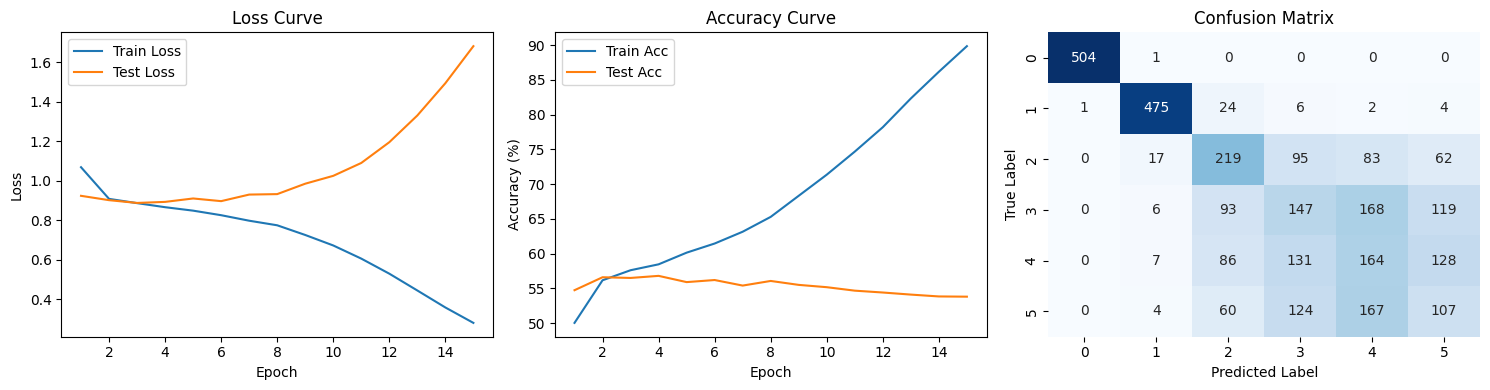


=== Training for noise 0.02 ===
Training on 12056 samples; Testing on 3015 samples
Epoch 5/15 Train Loss: 0.9804  Train Accuracy: 56.28%  Test Loss: 1.1204  Test Accuracy: 48.92%
Epoch 10/15 Train Loss: 0.5171  Train Accuracy: 80.24%  Test Loss: 1.6090  Test Accuracy: 47.96%
Epoch 15/15 Train Loss: 0.0775  Train Accuracy: 98.07%  Test Loss: 3.5142  Test Accuracy: 46.27%


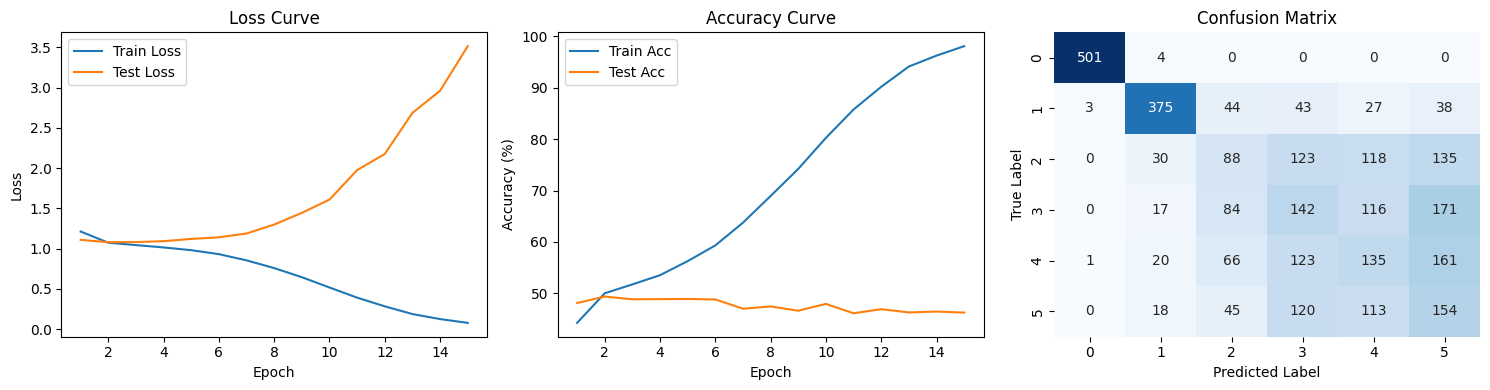


=== Training for noise 0.03 ===
Training on 12132 samples; Testing on 3033 samples
Epoch 5/15 Train Loss: 1.0775  Train Accuracy: 53.03%  Test Loss: 1.1673  Test Accuracy: 46.62%
Epoch 10/15 Train Loss: 0.7079  Train Accuracy: 72.02%  Test Loss: 1.5062  Test Accuracy: 44.08%
Epoch 15/15 Train Loss: 0.1787  Train Accuracy: 94.28%  Test Loss: 2.9437  Test Accuracy: 44.08%


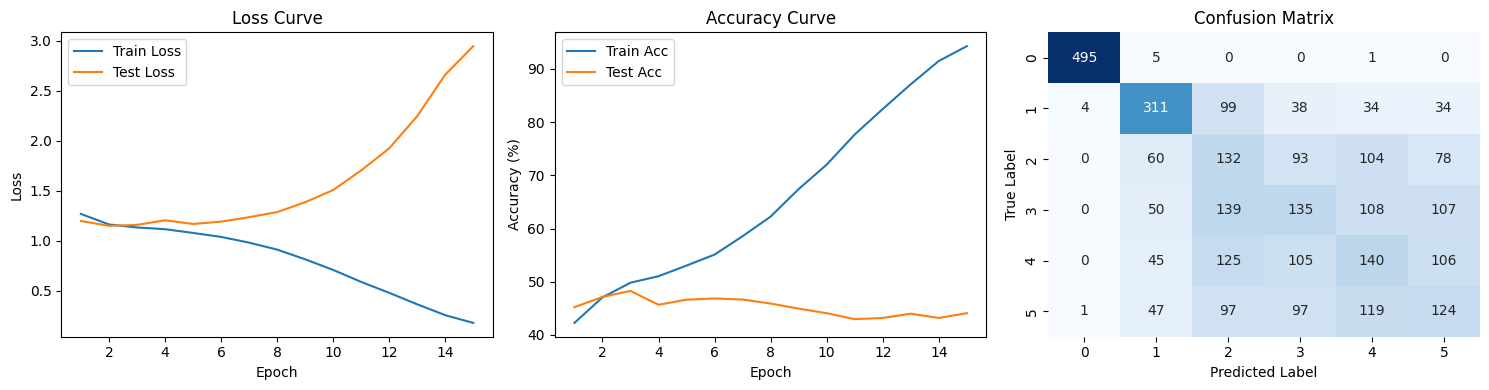


=== Training for noise 0.04 ===
Training on 11863 samples; Testing on 2966 samples
Epoch 5/15 Train Loss: 1.1403  Train Accuracy: 51.42%  Test Loss: 1.2403  Test Accuracy: 44.67%
Epoch 10/15 Train Loss: 0.7203  Train Accuracy: 72.54%  Test Loss: 1.7326  Test Accuracy: 41.91%
Epoch 15/15 Train Loss: 0.1650  Train Accuracy: 95.59%  Test Loss: 3.2453  Test Accuracy: 41.13%


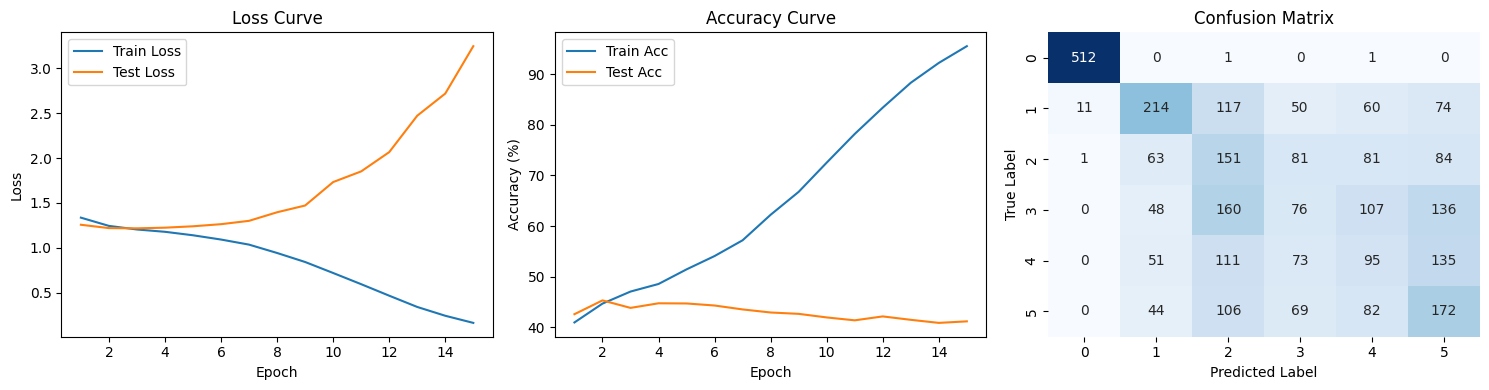


=== Training for noise 0.05 ===
Training on 9532 samples; Testing on 2384 samples
Epoch 5/15 Train Loss: 1.1794  Train Accuracy: 49.40%  Test Loss: 1.3336  Test Accuracy: 42.74%
Epoch 10/15 Train Loss: 0.8523  Train Accuracy: 66.63%  Test Loss: 1.5534  Test Accuracy: 40.98%
Epoch 15/15 Train Loss: 0.3333  Train Accuracy: 88.90%  Test Loss: 2.5634  Test Accuracy: 39.39%


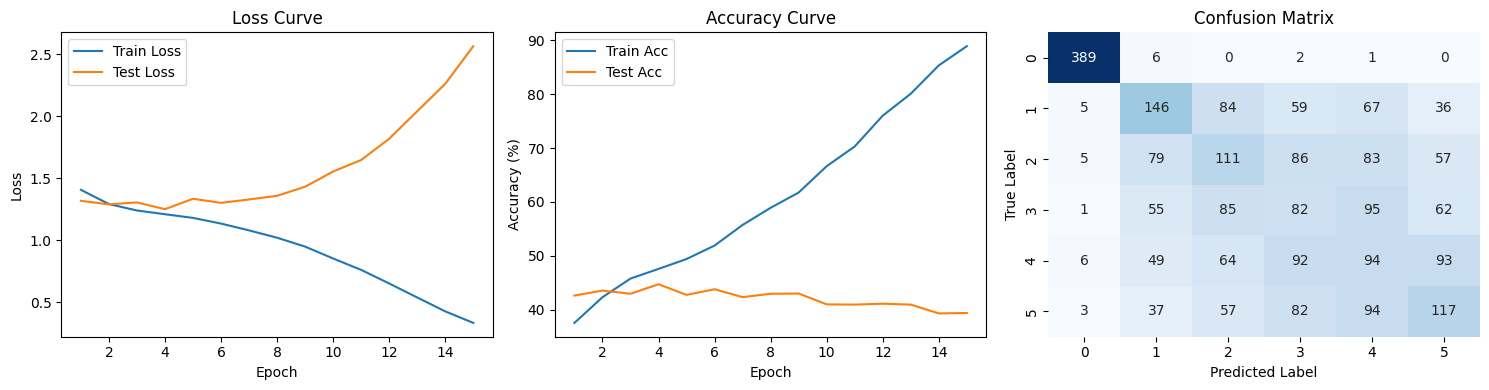

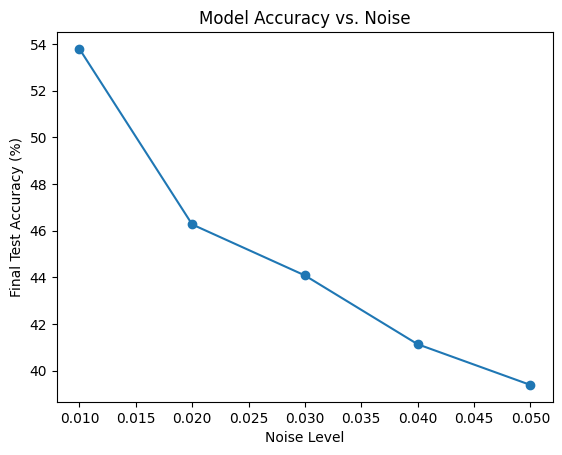

In [14]:
results = []

for noise_level in sorted(df['noise'].unique()):
    print(f'\n=== Training for noise {noise_level} ===')
    mask = df['noise'] == noise_level
    X = np.stack(df.loc[mask, 'time_trace'])
    y = df.loc[mask, 'dis_to_target'].values  

    n_bins = 6
    bins = np.linspace(y.min(), y.max(), n_bins + 1)
    y_class = np.digitize(y, bins[1:-1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test_s, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Define model for this run
    n_timepoints = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    model = CNNClassifier(n_timepoints, n_classes)

    # Train & evaluate (use your fit function)
    print(f"Training on {X_train.shape[0]} samples; Testing on {X_test.shape[0]} samples")
    train_losses, test_losses, train_accs, test_accs, conf_mat = fit(model, train_loader, test_loader, epochs=15)
    results.append({'noise': noise_level, 'test_acc': test_accs[-1], 'confusion_matrix': conf_mat})

# Plot performance vs. noise
plt.plot([r['noise'] for r in results], [r['test_acc'] for r in results], marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Model Accuracy vs. Noise") 
plt.show()